In [2]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
import time
from simulate import generateData
from linear_programs import checkMleExistence

In [3]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=4000

# number of (Gaussian) covariates
p=20

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [4]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

5.000000000000001

In [5]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [6]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

(array([79., 75., 79., 74., 63., 54., 45., 61., 62., 53., 44., 40., 42.,
        40., 39., 41., 48., 34., 37., 41., 36., 33., 39., 38., 43., 42.,
        27., 33., 29., 28., 33., 32., 27., 22., 26., 33., 32., 31., 29.,
        26., 30., 37., 30., 20., 29., 26., 33., 23., 29., 25., 18., 28.,
        26., 31., 30., 32., 30., 23., 36., 29., 35., 16., 35., 37., 25.,
        40., 30., 23., 27., 24., 35., 26., 28., 28., 33., 42., 37., 33.,
        40., 31., 41., 42., 46., 49., 39., 48., 52., 58., 48., 48., 46.,
        56., 60., 63., 54., 75., 57., 77., 75.]),
 array([6.05550524e-04, 1.05982987e-02, 2.05910468e-02, 3.05837949e-02,
        4.05765431e-02, 5.05692912e-02, 6.05620394e-02, 7.05547875e-02,
        8.05475356e-02, 9.05402838e-02, 1.00533032e-01, 1.10525780e-01,
        1.20518528e-01, 1.30511276e-01, 1.40504024e-01, 1.50496773e-01,
        1.60489521e-01, 1.70482269e-01, 1.80475017e-01, 1.90467765e-01,
        2.00460513e-01, 2.10453261e-01, 2.20446010e-01, 2.30438758e-01,
       

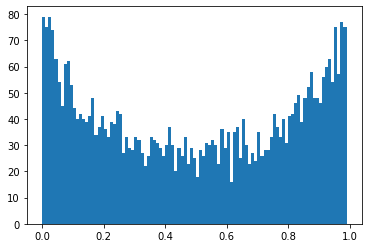

In [7]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([  1.,   0.,   0.,   0.,   1.,   4.,   1.,   1.,   4.,   3.,   3.,
          4.,   6.,   6.,   9.,  12.,  11.,  19.,  15.,  16.,  27.,  20.,
         32.,  34.,  35.,  47.,  48.,  52.,  41.,  60.,  79.,  67.,  71.,
         77.,  84., 101.,  93., 106., 116., 102., 102., 109., 125., 102.,
        119., 107., 115., 116., 127.,  97.,  96., 109., 108.,  92., 115.,
         97.,  84.,  89.,  71.,  72.,  70.,  59.,  44.,  54.,  36.,  34.,
         24.,  34.,  35.,  23.,  21.,  11.,  10.,  12.,  14.,   8.,   7.,
          9.,  11.,   4.,   6.,   2.,   2.,   2.,   0.,   3.,   1.,   0.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-7.40876682, -7.24436976, -7.07997269, -6.91557563, -6.75117856,
        -6.5867815 , -6.42238443, -6.25798737, -6.09359031, -5.92919324,
        -5.76479618, -5.60039911, -5.43600205, -5.27160498, -5.10720792,
        -4.94281085, -4.77841379, -4.61401672, -4.44961966, -4.28522259,
        -4.12082553, -3.95642846, -3.792

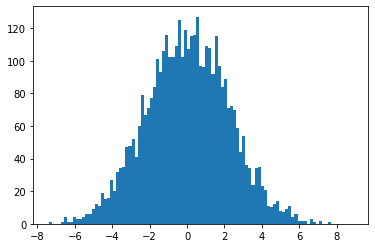

In [8]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [9]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.239251564625455
97.5th percentile: 4.318589933411571


In [55]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.1,0.51,0.01) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []

d1 = time.time()

# For each k_j in the grid, we do the following:
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 5
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    for i in range(B):
        subSample = df.sample(n=sampleSize) # draw the sample
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 
                                                        # the originial index from the dataframe
        
        mleStatus = checkMleExistence(subSample) # check if MLE exists
        # Note that checkMleExistence returns a coded value. The list of coded values can be
        # found here: https://www.gurobi.com/documentation/9.0/refman/optimization_status_codes.html
        # We are most interested in the number of times (out of B times) MLE does not exist.
        # If MLE does not exist, the checkMleExistence function will return status code 2 indicating that the 
        # LP has an optimal solution. 
        
        if mleStatus == 2:
            nMleDNE +=1
            
    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE does not exist
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j
    lKappa = kappaArray[uIdx-1] # kappa_j-1
else:
    print('Method Failed, All Subsamples are separable!')

d2 = time.time()
delta = round(d2 - d1)
print(kappaProportion, delta)

Method Failed, All Subsamples are separable!
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 2
